In [44]:
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit import Aer

As tree size increases, implementation gate length increases. We examine the optimal tree size at a fixed error rate 
p = ??

We consider one case as a proof of concept to avoid an excessive number of classical "if" operations.

In [52]:
def circuit_with_messenger_initialization(theta, direction):
    qr = QuantumRegister(16, 'qr')
    cr = ClassicalRegister(6, 'cr')
    circ16 = QuantumCircuit(qr, cr)
    for i in range(1, 16):
        circ16.h(i)
    circ16.cz(1, 2)
    circ16.cz(1, 3)
    circ16.cz(2, 4)
    circ16.cz(2, 5)
    circ16.cz(3, 6)
    circ16.cz(3, 7)
    circ16.cz(4, 8)
    circ16.cz(4, 9)
    circ16.cz(5, 10)
    circ16.cz(5, 11)
    circ16.cz(6, 12)
    circ16.cz(6, 13)
    circ16.cz(7, 14)
    circ16.cz(7, 15)
    circ16.barrier()
    # Initialize messenger qubit
    if direction == 'z':
        # Start in x eigenstate, rotate about z-axis
        circ16.h(0)
        circ16.p(theta, 0)
    
    if direction == 'x':
        circ16.h(0)
        circ16.p(-theta, 0)
        circ16.h(0)
        
    if direction == 'y':
        circ16.sdg(0); circ16.h(0)
        circ16.p(theta, 0)
        circ16.h(0); circ16.s(0)
        
    #bellmeasurement
    circ16.cx(0, 1)
    circ16.h(0)
    # Store x1 in cbit 1, x2 in cbit 2
    circ16.measure(0, 0)
    circ16.measure(1, 1)
    circ16.barrier()
    #store x3 in cbit 3
    circ16.measure(3, 2)
    
    #Z measurement on qubits in other (left) branch:
    circ16.measure(4, 3)
    circ16.measure(5, 4)
    
    #we can now reconstruct the messenger qubit state in qubit 2, the root qubit on the left
    circ16.h(2)
    circ16.measure(2, 5)
    
    #This works for the case where we lose none of the qubits 2-->5
    return circ16


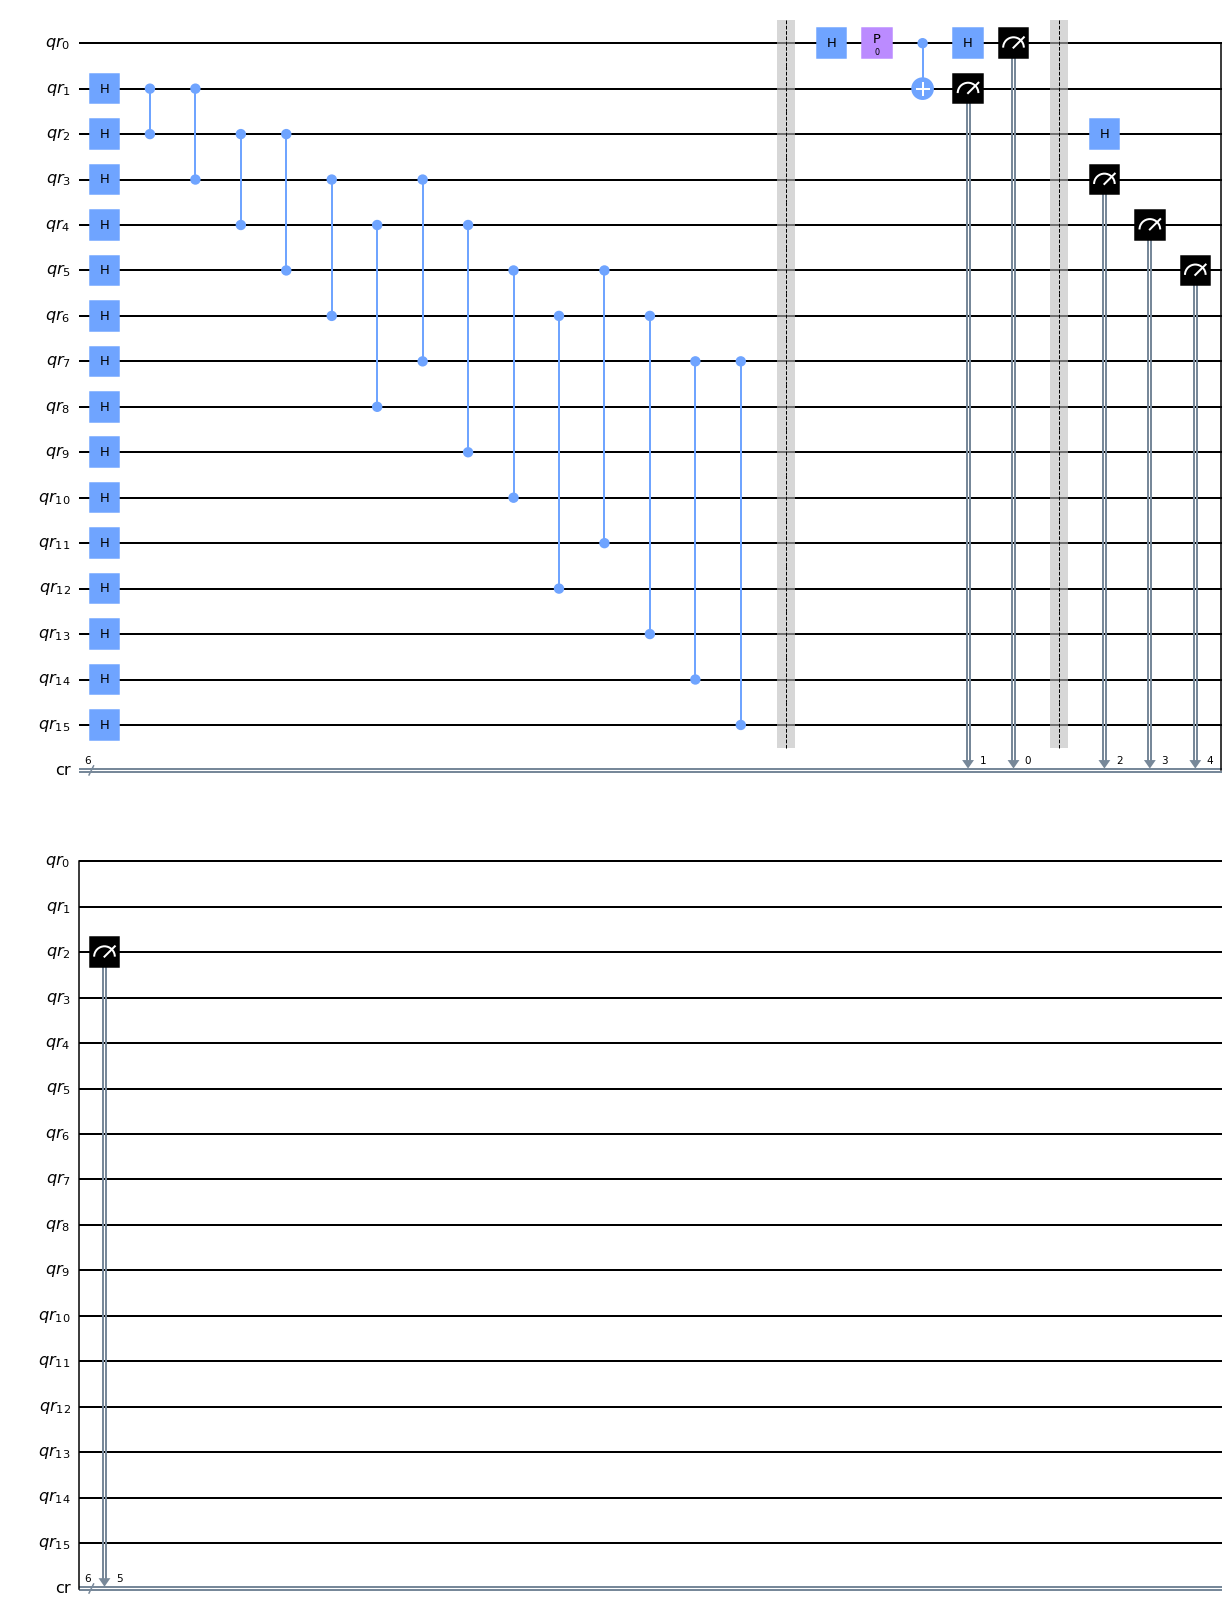

In [53]:
circuit_with_messenger_initialization(0, 'z').draw('mpl')

In [54]:
theta_list = np.linspace(0, np.pi, 20)
jobs_z = {}
backend = Aer.get_backend('qasm_simulator')

circ = circuit_with_messenger_initialization(0, 'z')
job = backend.run(transpile(circ, backend), shots = 10000)

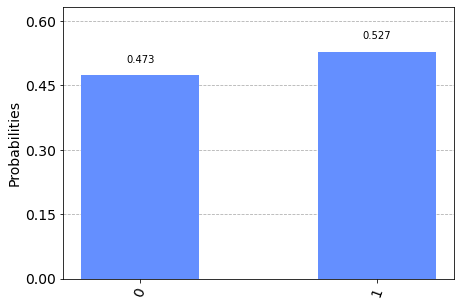

In [55]:
results = job.result()
counts = results.get_counts()
counts_filtered = {key[0] : val for key, val in counts.items() if key[1:]=='00000'}
plot_histogram(counts_filtered)

In [56]:
##Case 2: Lost the root photon of the right branch

In [60]:
def circuit_with_messenger_initialization_no_right_root(theta, direction):
    qr = QuantumRegister(16, 'qr')
    cr = ClassicalRegister(8, 'cr')
    circ16 = QuantumCircuit(qr, cr)
    for i in range(1, 16):
        circ16.h(i)
    circ16.cz(1, 2)
    circ16.cz(1, 3)
    circ16.cz(2, 4)
    circ16.cz(2, 5)
    circ16.cz(3, 6)
    circ16.cz(3, 7)
    circ16.cz(4, 8)
    circ16.cz(4, 9)
    circ16.cz(5, 10)
    circ16.cz(5, 11)
    circ16.cz(6, 12)
    circ16.cz(6, 13)
    circ16.cz(7, 14)
    circ16.cz(7, 15)
    circ16.barrier()
    # Initialize messenger qubit
    if direction == 'z':
        # Start in x eigenstate, rotate about z-axis
        circ16.h(0)
        circ16.p(theta, 0)
    
    if direction == 'x':
        circ16.h(0)
        circ16.p(-theta, 0)
        circ16.h(0)
        
    if direction == 'y':
        circ16.sdg(0); circ16.h(0)
        circ16.p(theta, 0)
        circ16.h(0); circ16.s(0)
        
    #bellmeasurement
    circ16.cx(0, 1)
    circ16.h(0)
    # Store x1 in cbit 1, x2 in cbit 2
    circ16.measure(0, 0)
    circ16.measure(1, 1)
    circ16.barrier()
    #LOST QUBIT 3 => need either subtree on the right to be full
    
    #X, Z, Z measurements on right subtree (qubits 7, 14, 15)
    circ16.h(7)
    circ16.measure(7, 2)
    circ16.measure(14, 3)
    circ16.measure(15, 4)
    
    #Z measurements on qubits in other (left) branch:
    circ16.measure(4, 5)
    circ16.measure(5, 6)
    
    #we can now reconstruct the messenger qubit state in qubit 2, the root qubit on the left
    circ16.h(2)
    circ16.measure(2, 7)
    
    #This works for the case where we lose none of the qubits 2-->5
    return circ16


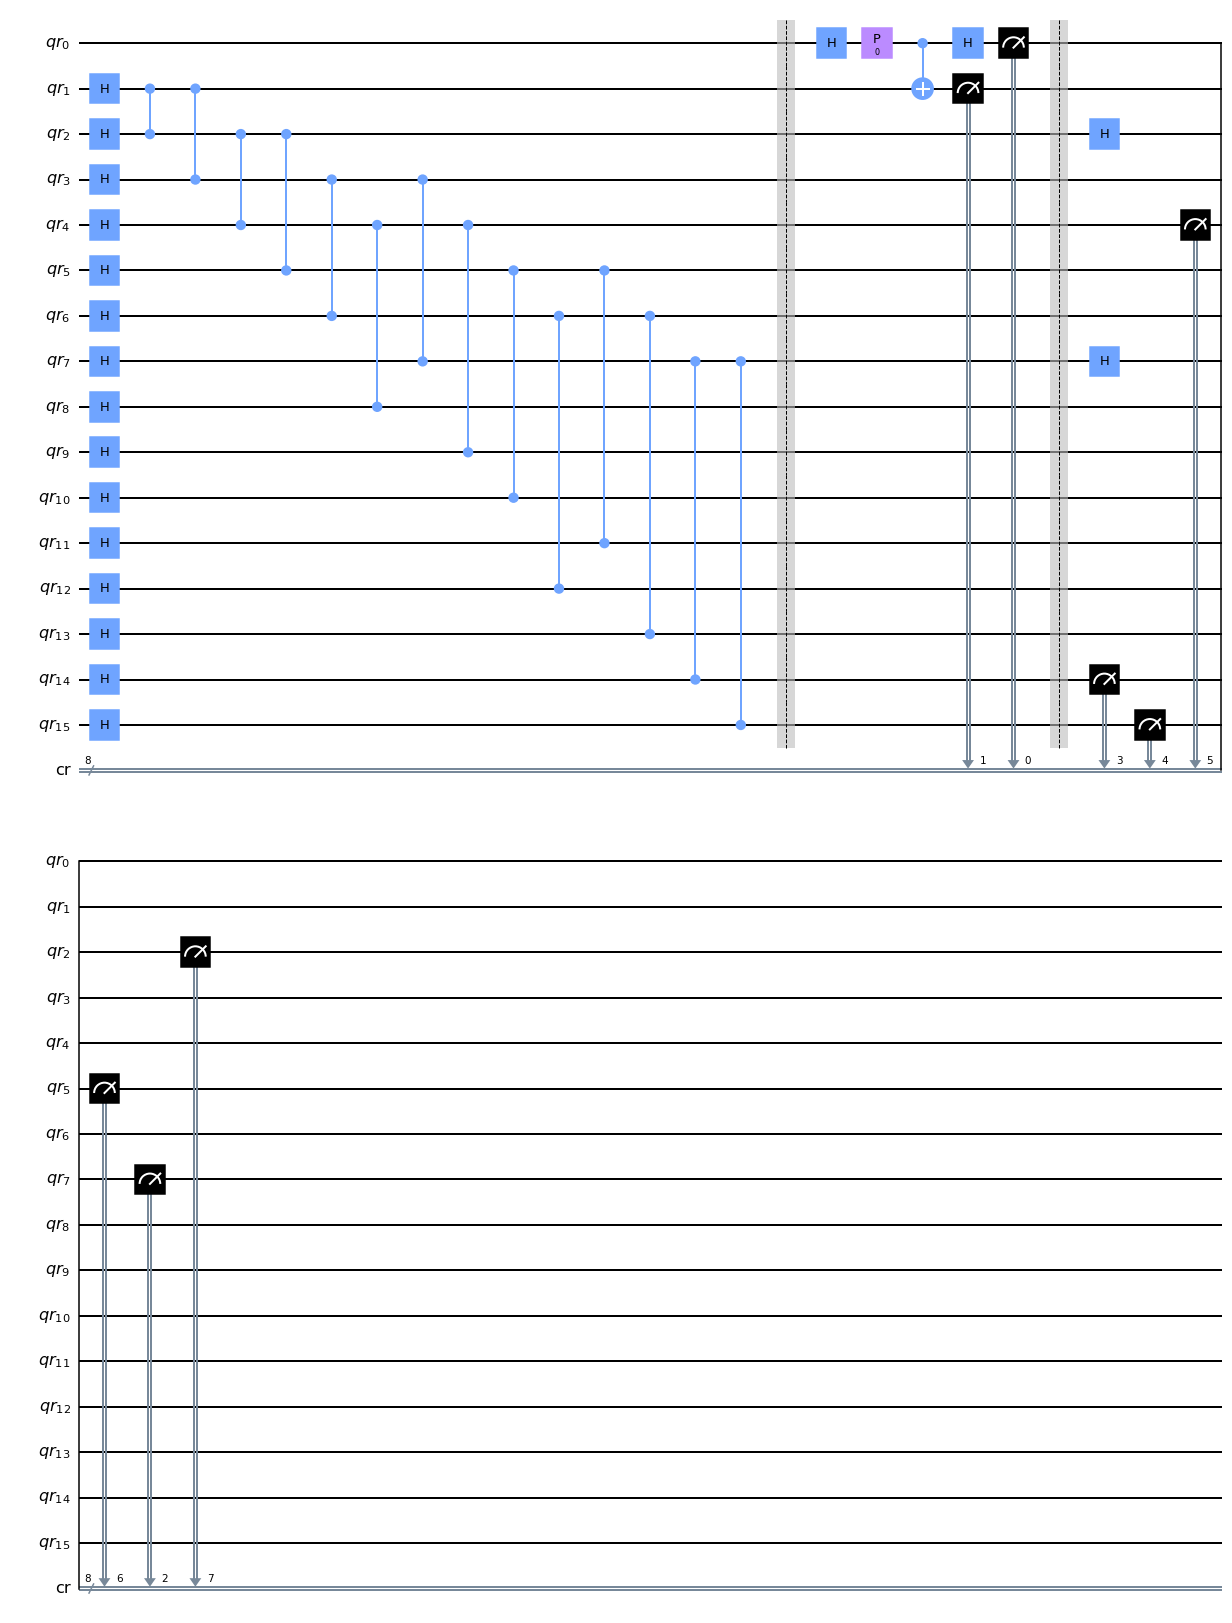

In [61]:
circuit_with_messenger_initialization_no_right_root(0, 'z').draw('mpl')

In [73]:
theta_list = np.linspace(0, np.pi, 20)
jobs_z = {}
backend = Aer.get_backend('qasm_simulator')

circ = circuit_with_messenger_initialization_no_right_root(0, 'z')
job = backend.run(transpile(circ, backend), shots = 10000)

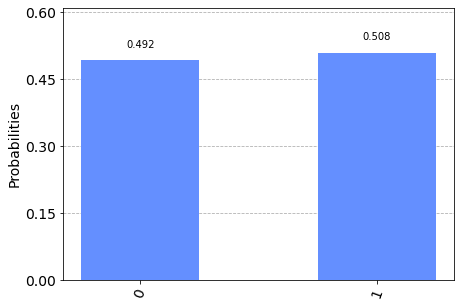

In [74]:
results = job.result()
counts = results.get_counts()
counts_filtered = {key[0] : val for key, val in counts.items() if key[1:]=='0000000'}
plot_histogram(counts_filtered)